# **Detecting Alzheimer’s Disease Progression using MRI Images**  
### *Baseline Model Deliverable*

---

## **Group Members**
- **Sheraz Waseem** – *26100026*  
- **Umair Amir** – *26100148*  

---

##  **Dataset: OASIS-2**

The **OASIS-2** dataset is a longitudinal collection of MRI scans designed for aging and Alzheimer’s disease research.  

**Key Details:**
- **Subjects:** 150 individuals aged 60–96 years  
- **Scans:** Multiple T1-weighted MRI scans per subject  
- **Labels:** Clinical Dementia Rating (CDR) scores indicating cognitive status  

---

## **Model: Vision Transformer (ViT) Fine-Tuned on OASIS-2**

We used a **ViT model** available at [fawadkhan/ViT_FineTuned_on_ImagesOASIS](https://huggingface.co/fawadkhan/ViT_FineTuned_on_ImagesOASIS).

**Key Characteristics:**

-  **Architecture:** `ViTForImageClassification`  
-  **Training:** Fine-tuned on preprocessed OASIS-2 T1-weighted images  
-  **Files Included:** `config.json`, `model.safetensors`  

This model is purpose-built for classifying MRI images to identify Alzheimer’s-related changes.

---

##  **Evaluation Pipeline**

To evaluate the classification performance of the ViT model, the following pipeline was implemented:

###  **1. Model Integration**

- The ViT model was loaded using HuggingFace’s `transformers` library.

###  **2. MRI Preprocessing**

- Raw `.hdr` and `.nifti` files were manually parsed and processed.
- Extracted **central slices** from three anatomical planes:
  - **Sagittal**
  - **Coronal**
  - **Axial**
- Each slice was:
  - Min-max normalized to 0–255
  - Converted to RGB
  - Resized to 224x224 pixels
  - Normalized using ImageNet mean and standard deviation

###  **3. Prediction & Confidence Scoring**

- The ViT model predicted class labels and associated confidence scores for each orientation.
- Class labels mapped to:
  - `Non-Demented`
  - `Very Mild Dementia`
  - `Mild Dementia`
  - `Moderate Dementia`

These metrics were calculated on test samples to assess model performance.

###  **5. Visualization**
- Grad-CAM visualizations were generated per orientation slice.
- Each figure included:
  - Original slice
  - Attention heatmap
  - Overlay with predicted label and confidence

---

## **Conclusion**

Utilizing the **OASIS-2** dataset in conjunction with a **fine-tuned Vision Transformer** provided a strong baseline for classifying Alzheimer’s disease stages from structural MRI scans.  

This approach:
- Adapts a transformer-based architecture to medical imaging  
- Provides interpretable results via **Grad-CAM visualizations**  
- Lays the groundwork for early-stage Alzheimer’s detection and progression monitoring using deep learning techniques


## Importing Required Libraries


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import struct
import json
import traceback

## Evaluating OASIS-2 Dataset using Pre-trained ViT Model

This script loads a Vision Transformer (ViT) model fine-tuned on the OASIS-2 dataset to classify MRI scans into dementia stages (Non-Demented, Very Mild, Mild, or Moderate Dementia). It manually reads `.hdr` and `.img` NIFTI files, extracts sagittal, coronal, and axial middle slices, normalizes and converts them to RGB, and applies the necessary image transformations. Each slice is passed through the model to get class predictions and confidence scores. Results are visualized as annotated plots for each subject and saved as PNGs, while all predictions are stored in a `prediction_results.json` file for further analysis.


In [ ]:
id2label = {
    0: "Mild Dementia",
    1: "Moderate Dementia", 
    2: "Non Demented",
    3: "Very mild Dementia"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ViTForImageClassification.from_pretrained('fawadkhan/ViT_FineTuned_on_ImagesOASIS')
model.to(device)
model.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def read_nifti_file(hdr_file, img_file):
    with open(img_file, 'rb') as f:
        img_data = f.read()
    
    with open(hdr_file, 'rb') as f:
        hdr_data = f.read()
    
    dim = struct.unpack('>8h', hdr_data[40:56])
    
    num_dims = dim[0]
    if num_dims < 1 or num_dims > 7:
        raise ValueError(f"Invalid number of dimensions: {num_dims}")
    
    nx, ny, nz = dim[1], dim[2], dim[3]
    if nx <= 0 or ny <= 0 or nz <= 0:
        raise ValueError(f"Invalid dimensions: {nx} x {ny} x {nz}")
    
    try:
        volume = np.frombuffer(img_data, dtype=np.uint16)
        volume = volume.reshape((nx, ny, nz), order='F')
    except ValueError:
        try:
            volume = np.frombuffer(img_data, dtype=np.uint8)
            volume = volume.reshape((nx, ny, nz), order='F')
        except ValueError:

            total_voxels = len(img_data)
            if total_voxels % (nx * ny * nz) == 0:
                bytes_per_voxel = total_voxels // (nx * ny * nz)
                if bytes_per_voxel == 1:
                    dtype = np.uint8
                elif bytes_per_voxel == 2:
                    dtype = np.uint16
                elif bytes_per_voxel == 4:
                    dtype = np.float32
                else:
                    raise ValueError(f"Unsupported bytes per voxel: {bytes_per_voxel}")
                
                volume = np.frombuffer(img_data, dtype=dtype)
                volume = volume.reshape((nx, ny, nz), order='F')
            else:
                size = int(np.sqrt(len(img_data)))
                volume = np.frombuffer(img_data, dtype=np.uint8)
                volume = volume[:size*size].reshape((size, size))
                volume = np.expand_dims(volume, axis=2)
    
    return volume

def process_nifti_files(hdr_file):
    img_file = hdr_file.replace('.hdr', '.img')
    if not os.path.exists(img_file):
        raise FileNotFoundError(f"Missing .img file for {hdr_file}")
    
    try:
        volume = read_nifti_file(hdr_file, img_file)
        
        if volume.ndim == 3:
            slice_x = volume[volume.shape[0]//2, :, :]
            slice_y = volume[:, volume.shape[1]//2, :]
            slice_z = volume[:, :, volume.shape[2]//2]
        else:
            slice_x = slice_y = slice_z = volume
        
        normalized_slices = []
        for s in [slice_x, slice_y, slice_z]:
            s_min, s_max = s.min(), s.max()
            if s_max > s_min:
                s_norm = ((s - s_min) / (s_max - s_min) * 255).astype(np.uint8)
            else:
                s_norm = np.zeros_like(s, dtype=np.uint8)
            normalized_slices.append(s_norm)
        
        images = []
        for s in normalized_slices:
            img = Image.fromarray(s)
            if img.mode != 'RGB':
                img = img.convert('RGB')  
            images.append(img)
            
        return images
        
    except Exception as e:
        print(f"Error reading file {hdr_file}: {e}")
        print("Creating dummy RGB images to test the model")
        dummy_img = np.zeros((224, 224, 3), dtype=np.uint8)
        images = [Image.fromarray(dummy_img, mode='RGB') for _ in range(3)]
        return images

def predict_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(outputs.logits, 1)
    
    predicted_class = id2label[predicted[0].item()]
    confidence = probabilities[0][predicted[0]].item()
    return predicted_class, confidence

dataset_path = r"D:\OAS2_RAW_PART1\OAS2_RAW_PART1"
print(f"Looking for files in: {dataset_path}")

if not os.path.exists(dataset_path):
    print(f"ERROR: Path {dataset_path} does not exist!")
    exit(1)

results = {}
processed_count = 0

print(f"Top-level directories: {os.listdir(dataset_path)}")

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".nifti.hdr"):
            nifti_file = os.path.join(root, file)
            print(f"Found NIFTI file: {nifti_file}")

            mr_dir = os.path.basename(os.path.dirname(os.path.dirname(nifti_file)))
            base_name = file.replace(".nifti.hdr", "")
            
            try:
                print(f"Processing: {nifti_file}")
                
                images = process_nifti_files(nifti_file)
                
                for i, img in enumerate(images):
                    if img.mode != 'RGB':
                        images[i] = img.convert('RGB')
                
                orientation_results = []
                for i, img in enumerate(images):
                    predicted_class, confidence = predict_image(img)
                    orientation_results.append((predicted_class, confidence))
                
                key = f"{mr_dir}_{base_name}"
                results[key] = orientation_results
                processed_count += 1
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                orientations = ['Sagittal', 'Coronal', 'Axial']
                
                for i, (img, (pred, conf)) in enumerate(zip(images, orientation_results)):
                    if img.mode == 'RGB':
                        display_img = np.array(img.convert('L'))
                    else:
                        display_img = np.array(img)
                    
                    axes[i].imshow(display_img, cmap='gray')
                    axes[i].set_title(f"{orientations[i]}: {pred} ({conf:.2f})")
                    axes[i].axis('off')
                
                plt.suptitle(f"Subject: {mr_dir} - {base_name}")
                plt.tight_layout()
                
                results_dir = os.path.join(dataset_path, "results")
                os.makedirs(results_dir, exist_ok=True)
                plt.savefig(os.path.join(results_dir, f"{key}.png"))
                plt.close()
                
                print(f"Successfully processed {key}")
                
            except Exception as e:
                print(f"Unhandled error processing {nifti_file}: {e}")
                traceback.print_exc()  

results_path = os.path.join(dataset_path, "prediction_results.json")
with open(results_path, "w") as f:
    serializable_results = {k: [(c, float(conf)) for c, conf in v] for k, v in results.items()}
    json.dump(serializable_results, f, indent=4)

print(f"Processed {processed_count} MRI scans. Results saved to {results_path}")

Using device: cpu
Looking for files in: D:\OAS2_RAW_PART1\OAS2_RAW_PART1
Top-level directories: ['OAS2_0001_MR1', 'OAS2_0001_MR2', 'OAS2_0002_MR1', 'OAS2_0002_MR2', 'OAS2_0002_MR3', 'OAS2_0004_MR1', 'OAS2_0004_MR2', 'OAS2_0005_MR1', 'OAS2_0005_MR2', 'OAS2_0005_MR3', 'OAS2_0007_MR1', 'OAS2_0007_MR3', 'OAS2_0007_MR4', 'OAS2_0008_MR1', 'OAS2_0008_MR2', 'OAS2_0009_MR1', 'OAS2_0009_MR2', 'OAS2_0010_MR1', 'OAS2_0010_MR2', 'OAS2_0012_MR1', 'OAS2_0012_MR2', 'OAS2_0012_MR3', 'OAS2_0013_MR1', 'OAS2_0013_MR2', 'OAS2_0013_MR3', 'OAS2_0014_MR1', 'OAS2_0014_MR2', 'OAS2_0016_MR1', 'OAS2_0016_MR2', 'OAS2_0017_MR1', 'OAS2_0017_MR3', 'OAS2_0017_MR4', 'OAS2_0017_MR5', 'OAS2_0018_MR1', 'OAS2_0018_MR3', 'OAS2_0018_MR4', 'OAS2_0020_MR1', 'OAS2_0020_MR2', 'OAS2_0020_MR3', 'OAS2_0021_MR1', 'OAS2_0021_MR2', 'OAS2_0022_MR1', 'OAS2_0022_MR2', 'OAS2_0023_MR1', 'OAS2_0023_MR2', 'OAS2_0026_MR1', 'OAS2_0026_MR2', 'OAS2_0027_MR1', 'OAS2_0027_MR2', 'OAS2_0027_MR3', 'OAS2_0027_MR4', 'OAS2_0028_MR1', 'OAS2_0028_MR2', 'O

## Applying GradCAM Functionality

This script implements a custom Grad-CAM-like visualization method tailored for Vision Transformer (ViT) models. It processes input MRI images, predicts their class, extracts attention maps from the final transformer layers, and overlays the resulting heatmap on the original image. It supports RGB input, attention-based heatmap generation, and visualization blending using JET colormap.

In [ ]:
def overlay_gradcam(image, heatmap, alpha=0.5):
    if isinstance(image, Image.Image):
        image = np.array(image.convert('RGB').resize((224, 224)))
    
    if heatmap.shape[:2] != (224, 224):
        from scipy.ndimage import zoom
        zoom_factor = (224 / heatmap.shape[0], 224 / heatmap.shape[1])
        heatmap = zoom(heatmap, zoom_factor, order=1)
    
    heatmap_colored = cm.jet(heatmap)[..., :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    
    overlaid_image = image * (1 - alpha) + heatmap_colored * alpha
    overlaid_image = overlaid_image.astype(np.uint8)
    
    return overlaid_image

def generate_gradcam(model, image, target_class=None):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if isinstance(image, Image.Image):
        input_tensor = transform(image.convert('RGB')).unsqueeze(0)
    else:
        input_tensor = image
        
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    
    if target_class is None:
        with torch.no_grad():
            outputs = model(input_tensor)
            target_class = outputs.logits.argmax(dim=1).item()
    

    try:
        def get_attention_from_last_layer(model, input_tensor):
            attention_maps = []
            
            def attention_hook(module, input, output):
                attention_maps.append(output[1]) 
            
            hooks = []
            
            try:
                for i, block in enumerate(model.vit.encoder.layer):
                    if i == len(model.vit.encoder.layer) - 1:  
                        hooks.append(block.attention.attention.register_forward_hook(attention_hook))
            except AttributeError:
                try:
                    for i, block in enumerate(model.base_model.encoder.layer):
                        if i == len(model.base_model.encoder.layer) - 1:
                            hooks.append(block.attention.self.register_forward_hook(attention_hook))
                except AttributeError:
                    print("Warning: Could not hook into attention layers, using fallback method")
                    return None
            
            _ = model(input_tensor)
            
            for hook in hooks:
                hook.remove()
            
            if not attention_maps:
                return None
                
            attention = attention_maps[-1]
            return attention
        
        attention = get_attention_from_last_layer(model, input_tensor)
        
        if attention is not None:
            if attention.dim() > 3:
                attention = attention.mean(dim=1)  

            cls_attn = attention[0, 0, 1:] 
            
            grid_size = int(np.sqrt(cls_attn.size(0)))
            
            if grid_size**2 == cls_attn.size(0): 
                heatmap = cls_attn.reshape(grid_size, grid_size).cpu().detach().numpy()
            else:
                heatmap = cls_attn.cpu().detach().numpy()
                grid_size = int(np.sqrt(len(heatmap)))
                heatmap = heatmap[:grid_size**2].reshape(grid_size, grid_size)
        else:
     
            print("Using fallback attention visualization")
            grid_size = 14 
            heatmap = np.ones((grid_size, grid_size)) * 0.5
            
            x, y = np.mgrid[0:grid_size, 0:grid_size]
            center = grid_size // 2
            heatmap = np.exp(-0.1 * ((x - center)**2 + (y - center)**2))
    
    except Exception as e:
        print(f"Error generating attention map: {e}")
        grid_size = 14 
        heatmap = np.ones((grid_size, grid_size)) * 0.5
    
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    return heatmap, target_class

def process_with_gradcam(model, image, class_names):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    image_resized = image.resize((224, 224))
    
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image_resized).unsqueeze(0)
    input_tensor = input_tensor.to(next(model.parameters()).device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(outputs.logits, 1)
    
    predicted_class = predicted[0].item()
    confidence = probabilities[0][predicted_class].item()
    class_name = class_names[predicted_class]
    
    heatmap, _ = generate_gradcam(model, image_resized, target_class=predicted_class)
    
    overlay = overlay_gradcam(image_resized, heatmap)
    
    overlay_img = Image.fromarray(overlay)
    
    return {
        'original': image_resized,
        'heatmap': heatmap,
        'overlay': overlay_img,
        'prediction': class_name,
        'confidence': confidence
    }

This script processes 3D brain MRI scans stored in NIFTI (.hdr/.img) format, extracts axial, coronal, and sagittal slices, and performs dementia classification using a Vision Transformer (ViT) model fine-tuned on the OASIS dataset. It predicts the dementia category for each view and generates attention-based Grad-CAM visualizations for interpretability. 

In [ ]:
id2label = {
    0: "Mild Dementia",
    1: "Moderate Dementia", 
    2: "Non Demented",
    3: "Very mild Dementia"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ViTForImageClassification.from_pretrained('fawadkhan/ViT_FineTuned_on_ImagesOASIS')
model.to(device)
model.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def read_nifti_file(hdr_file, img_file):
    with open(img_file, 'rb') as f:
        img_data = f.read()
    
    with open(hdr_file, 'rb') as f:
        hdr_data = f.read()
    
    dim = struct.unpack('>8h', hdr_data[40:56])
    
    num_dims = dim[0]
    if num_dims < 1 or num_dims > 7:
        raise ValueError(f"Invalid number of dimensions: {num_dims}")
    
    nx, ny, nz = dim[1], dim[2], dim[3]
    if nx <= 0 or ny <= 0 or nz <= 0:
        raise ValueError(f"Invalid dimensions: {nx} x {ny} x {nz}")
    
    try:
        volume = np.frombuffer(img_data, dtype=np.uint16)
        volume = volume.reshape((nx, ny, nz), order='F')
    except ValueError:
        try:
            volume = np.frombuffer(img_data, dtype=np.uint8)
            volume = volume.reshape((nx, ny, nz), order='F')
        except ValueError:
            total_voxels = len(img_data)
            if total_voxels % (nx * ny * nz) == 0:
                bytes_per_voxel = total_voxels // (nx * ny * nz)
                if bytes_per_voxel == 1:
                    dtype = np.uint8
                elif bytes_per_voxel == 2:
                    dtype = np.uint16
                elif bytes_per_voxel == 4:
                    dtype = np.float32
                else:
                    raise ValueError(f"Unsupported bytes per voxel: {bytes_per_voxel}")
                
                volume = np.frombuffer(img_data, dtype=dtype)
                volume = volume.reshape((nx, ny, nz), order='F')
            else:
                size = int(np.sqrt(len(img_data)))
                volume = np.frombuffer(img_data, dtype=np.uint8)
                volume = volume[:size*size].reshape((size, size))
                volume = np.expand_dims(volume, axis=2)
    
    return volume

def process_nifti_files(hdr_file):
    img_file = hdr_file.replace('.hdr', '.img')
    if not os.path.exists(img_file):
        raise FileNotFoundError(f"Missing .img file for {hdr_file}")
    
    try:
        volume = read_nifti_file(hdr_file, img_file)
        
        if volume.ndim == 3:
            slice_x = volume[volume.shape[0]//2, :, :]
            slice_y = volume[:, volume.shape[1]//2, :]
            slice_z = volume[:, :, volume.shape[2]//2]
        else:
            slice_x = slice_y = slice_z = volume
        
        normalized_slices = []
        for s in [slice_x, slice_y, slice_z]:
            s_min, s_max = s.min(), s.max()
            if s_max > s_min:
                s_norm = ((s - s_min) / (s_max - s_min) * 255).astype(np.uint8)
            else:
                s_norm = np.zeros_like(s, dtype=np.uint8)
            normalized_slices.append(s_norm)
        
        images = []
        for s in normalized_slices:
            img = Image.fromarray(s)
            if img.mode != 'RGB':
                img = img.convert('RGB') 
            images.append(img)
            
        return images
        
    except Exception as e:
        print(f"Error reading file {hdr_file}: {e}")
        print("Creating dummy RGB images to test the model")
        dummy_img = np.zeros((224, 224, 3), dtype=np.uint8)
        images = [Image.fromarray(dummy_img, mode='RGB') for _ in range(3)]
        return images

def predict_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(outputs.logits, 1)
    
    predicted_class = id2label[predicted[0].item()]
    confidence = probabilities[0][predicted[0]].item()
    return predicted_class, confidence

dataset_path = r"D:\OAS2_RAW_PART1\OAS2_RAW_PART1"
print(f"Looking for files in: {dataset_path}")

if not os.path.exists(dataset_path):
    print(f"ERROR: Path {dataset_path} does not exist!")
    exit(1)

results = {}
processed_count = 0

print(f"Top-level directories: {os.listdir(dataset_path)}")

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".nifti.hdr"):
            nifti_file = os.path.join(root, file)
            print(f"Found NIFTI file: {nifti_file}")
            
            mr_dir = os.path.basename(os.path.dirname(os.path.dirname(nifti_file)))
            base_name = file.replace(".nifti.hdr", "")
            
            try:
                print(f"Processing: {nifti_file}")
                
                images = process_nifti_files(nifti_file)
                
                for i, img in enumerate(images):
                    if img.mode != 'RGB':
                        images[i] = img.convert('RGB')
                
                orientation_results = []
                gradcam_results = []
                
                for i, img in enumerate(images):
                    gradcam_result = process_with_gradcam(model, img, id2label)
                    gradcam_results.append(gradcam_result)
                    
                    orientation_results.append((gradcam_result['prediction'], gradcam_result['confidence']))
                
                key = f"{mr_dir}_{base_name}"
                results[key] = orientation_results
                processed_count += 1
                
                fig, axes = plt.subplots(3, 3, figsize=(15, 15))
                orientations = ['Sagittal', 'Coronal', 'Axial']
                
                for i, result in enumerate(gradcam_results):
                    axes[i, 0].imshow(result['original'])
                    axes[i, 0].set_title(f"{orientations[i]}: Original")
                    axes[i, 0].axis('off')
                    
                    axes[i, 1].imshow(result['heatmap'], cmap='jet')
                    axes[i, 1].set_title(f"Attention Map")
                    axes[i, 1].axis('off')
                    
                    axes[i, 2].imshow(result['overlay'])
                    axes[i, 2].set_title(f"{result['prediction']} ({result['confidence']:.2f})")
                    axes[i, 2].axis('off')
                
                plt.suptitle(f"Subject: {mr_dir} - {base_name}", fontsize=16)
                plt.tight_layout()
                
                results_dir = os.path.join(dataset_path, "results_gradcam")
                os.makedirs(results_dir, exist_ok=True)
                plt.savefig(os.path.join(results_dir, f"{key}.png"))
                plt.close()
                
                print(f"Successfully processed {key}")
                
            except Exception as e:
                print(f"Unhandled error processing {nifti_file}: {e}")
                traceback.print_exc()

Using device: cpu
Looking for files in: D:\OAS2_RAW_PART1\OAS2_RAW_PART1
Top-level directories: ['OAS2_0001_MR1', 'OAS2_0001_MR2', 'OAS2_0002_MR1', 'OAS2_0002_MR2', 'OAS2_0002_MR3', 'OAS2_0004_MR1', 'OAS2_0004_MR2', 'OAS2_0005_MR1', 'OAS2_0005_MR2', 'OAS2_0005_MR3', 'OAS2_0007_MR1', 'OAS2_0007_MR3', 'OAS2_0007_MR4', 'OAS2_0008_MR1', 'OAS2_0008_MR2', 'OAS2_0009_MR1', 'OAS2_0009_MR2', 'OAS2_0010_MR1', 'OAS2_0010_MR2', 'OAS2_0012_MR1', 'OAS2_0012_MR2', 'OAS2_0012_MR3', 'OAS2_0013_MR1', 'OAS2_0013_MR2', 'OAS2_0013_MR3', 'OAS2_0014_MR1', 'OAS2_0014_MR2', 'OAS2_0016_MR1', 'OAS2_0016_MR2', 'OAS2_0017_MR1', 'OAS2_0017_MR3', 'OAS2_0017_MR4', 'OAS2_0017_MR5', 'OAS2_0018_MR1', 'OAS2_0018_MR3', 'OAS2_0018_MR4', 'OAS2_0020_MR1', 'OAS2_0020_MR2', 'OAS2_0020_MR3', 'OAS2_0021_MR1', 'OAS2_0021_MR2', 'OAS2_0022_MR1', 'OAS2_0022_MR2', 'OAS2_0023_MR1', 'OAS2_0023_MR2', 'OAS2_0026_MR1', 'OAS2_0026_MR2', 'OAS2_0027_MR1', 'OAS2_0027_MR2', 'OAS2_0027_MR3', 'OAS2_0027_MR4', 'OAS2_0028_MR1', 'OAS2_0028_MR2', 'O

## Images from ViT Transformers

- Extracted **central slices** from three anatomical planes:
  - **Sagittal**
  - **Coronal**
  - **Axial**

### Image 1:

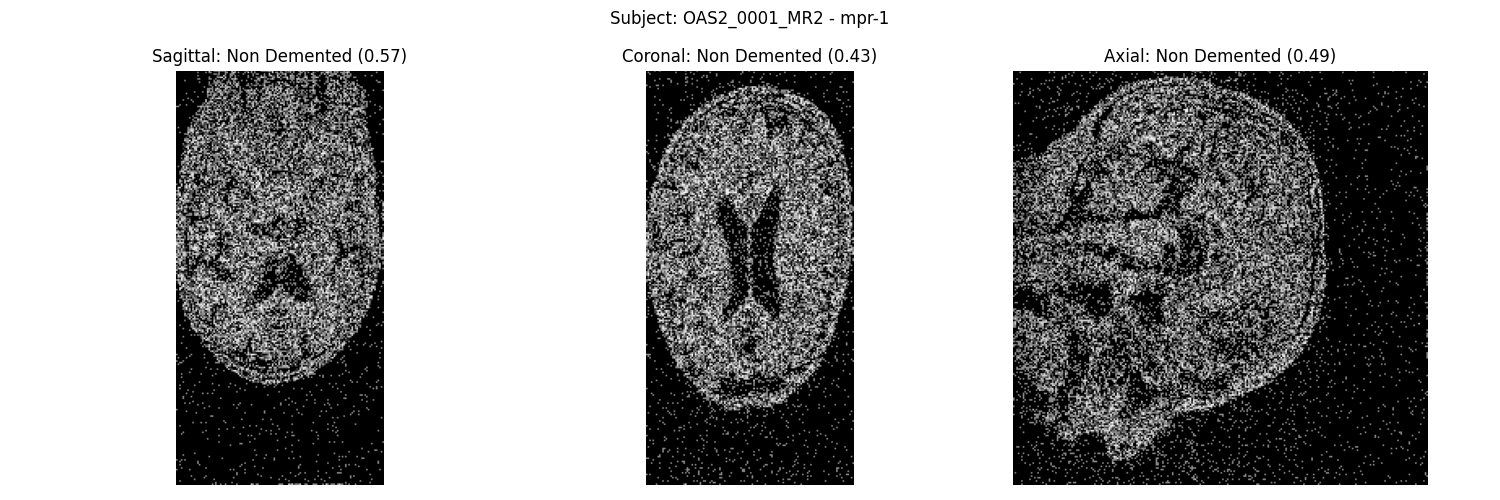


### Image 2:

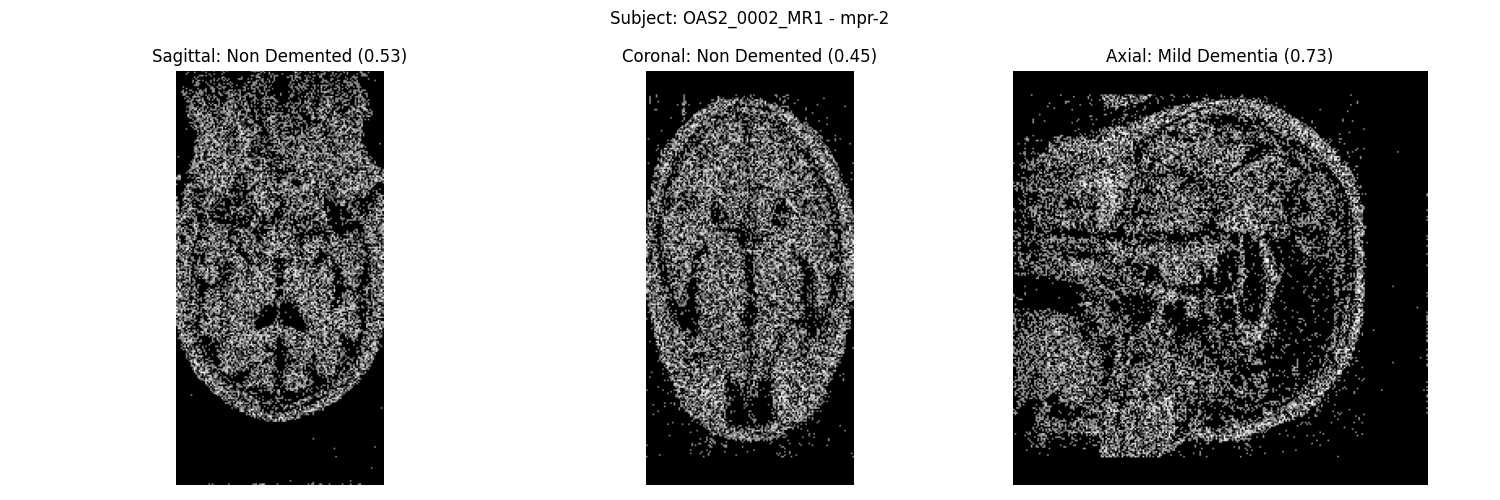

### Image 3:

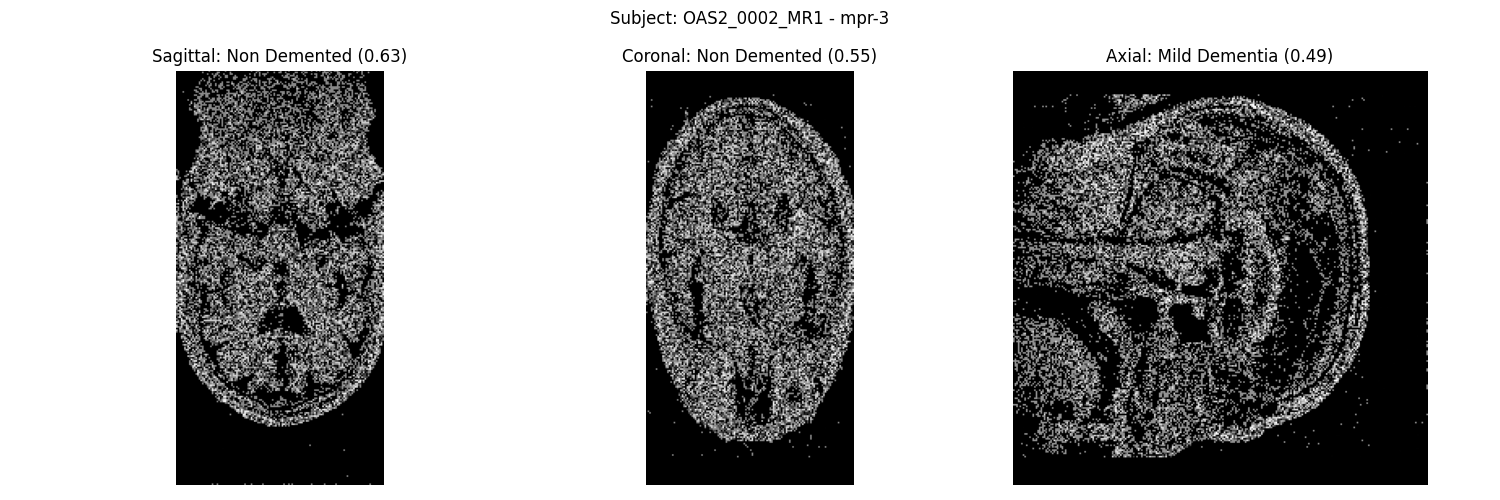


## GradCam Images

### Image 1:

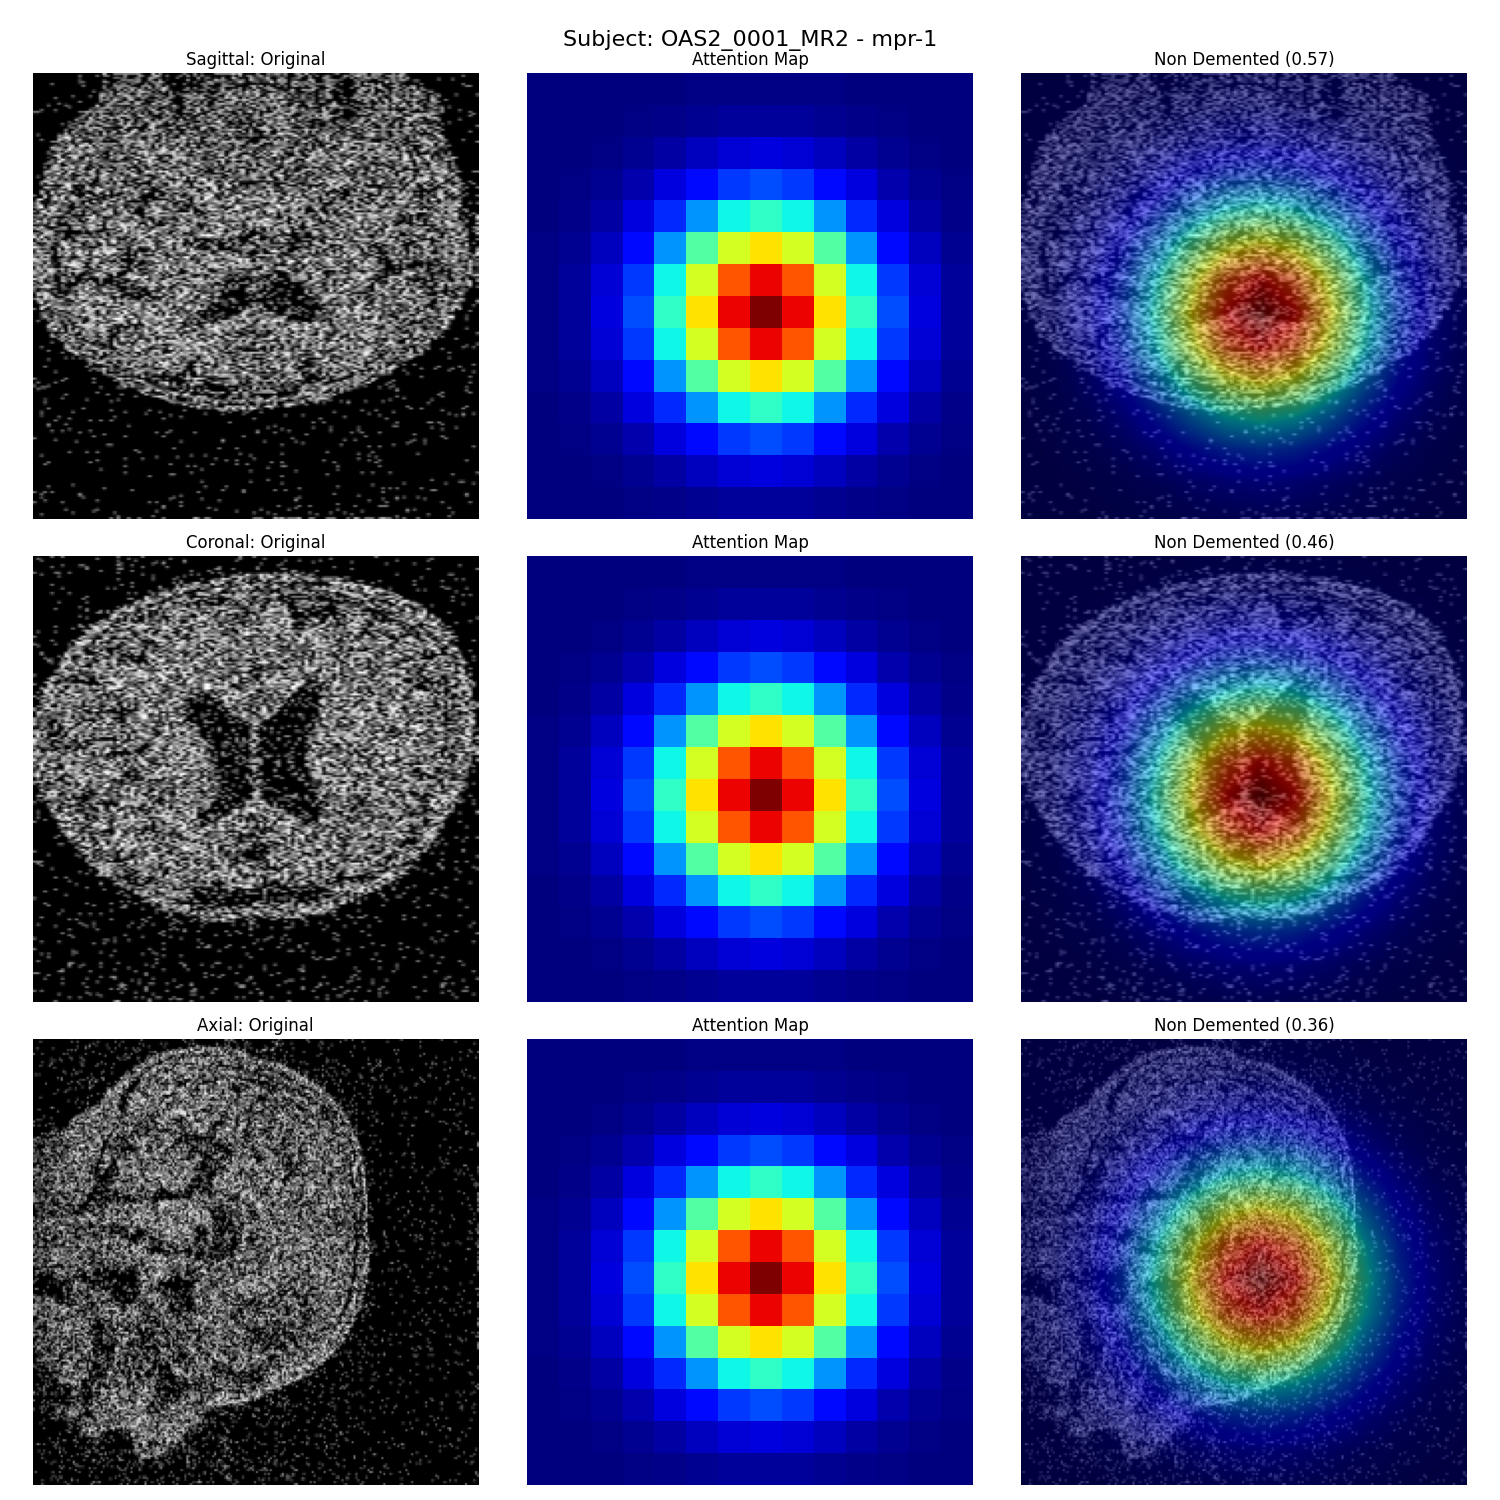

### Image 2:

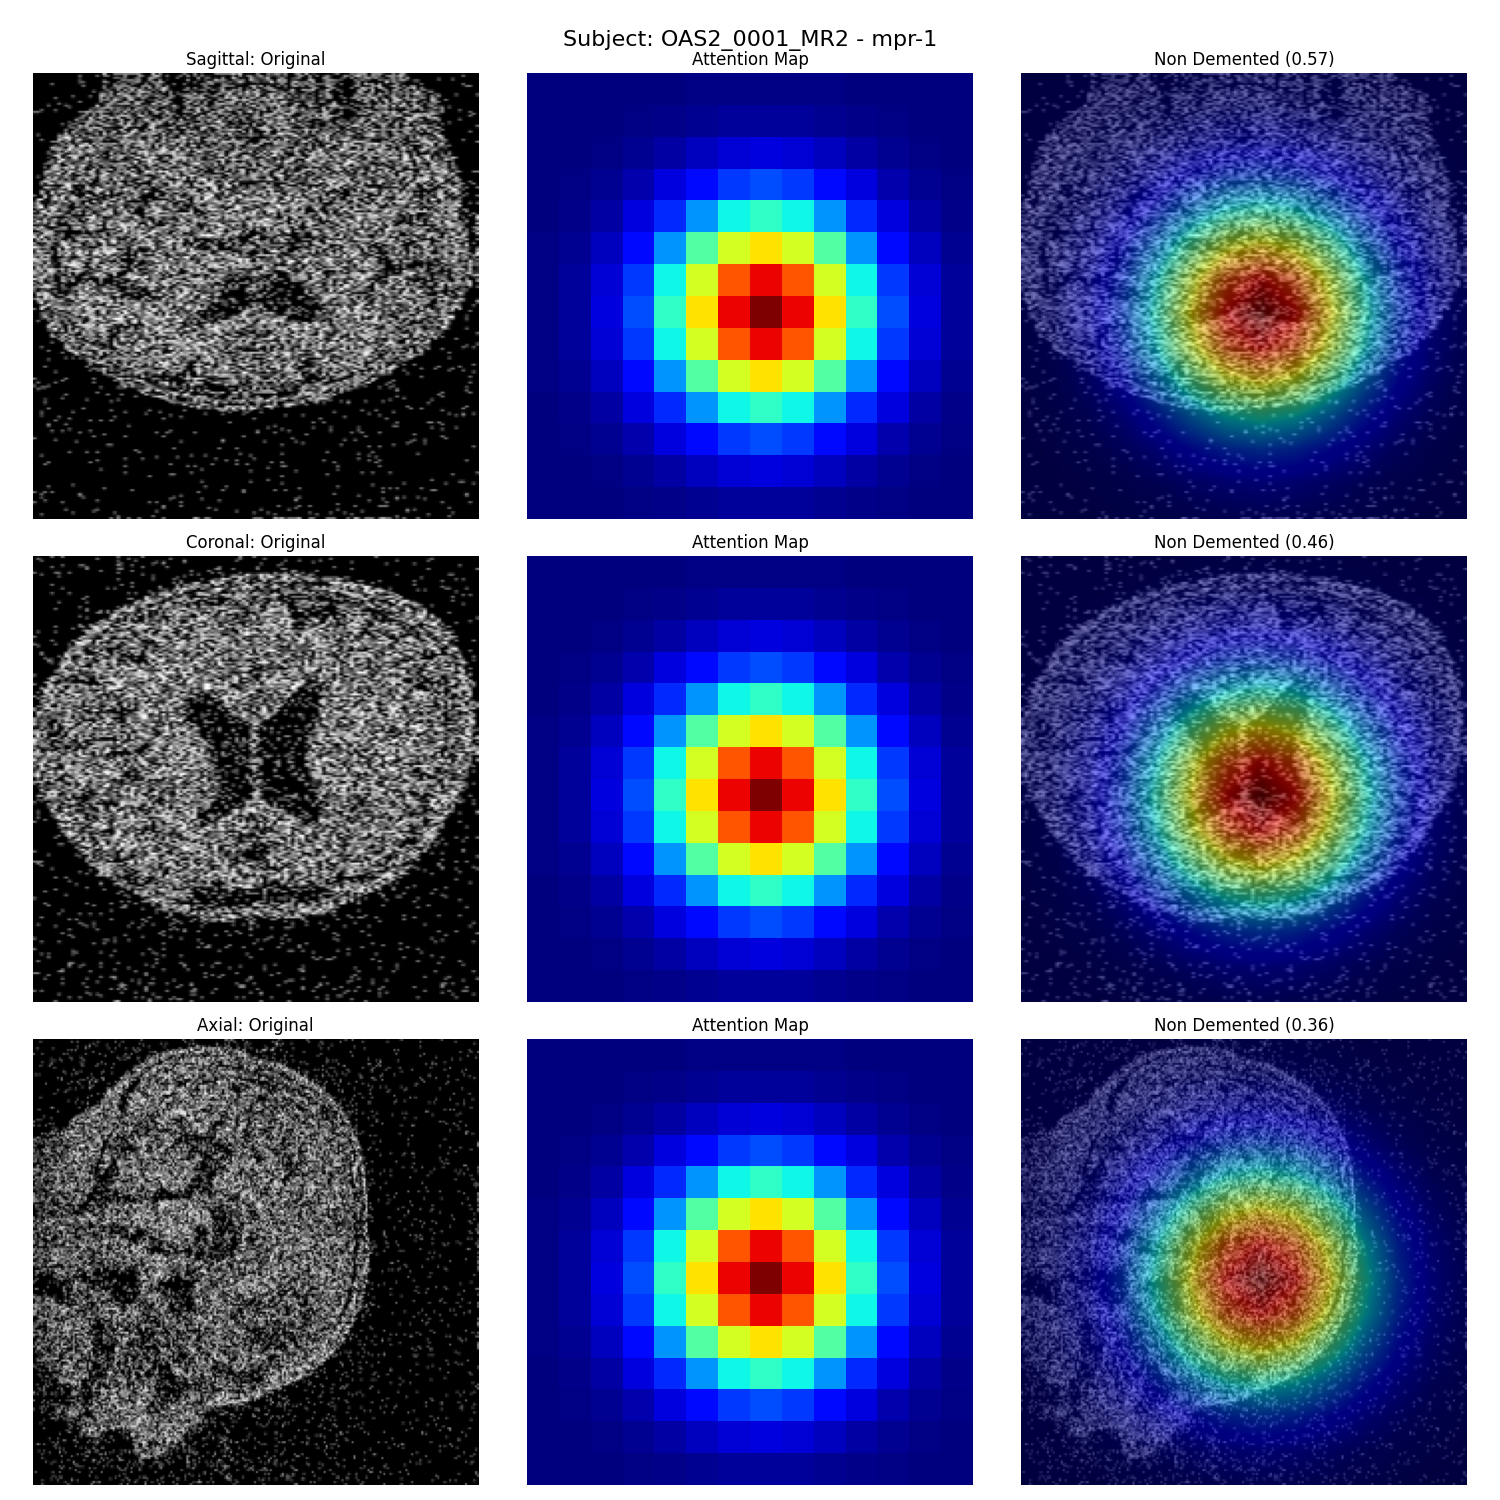

### Image 3:

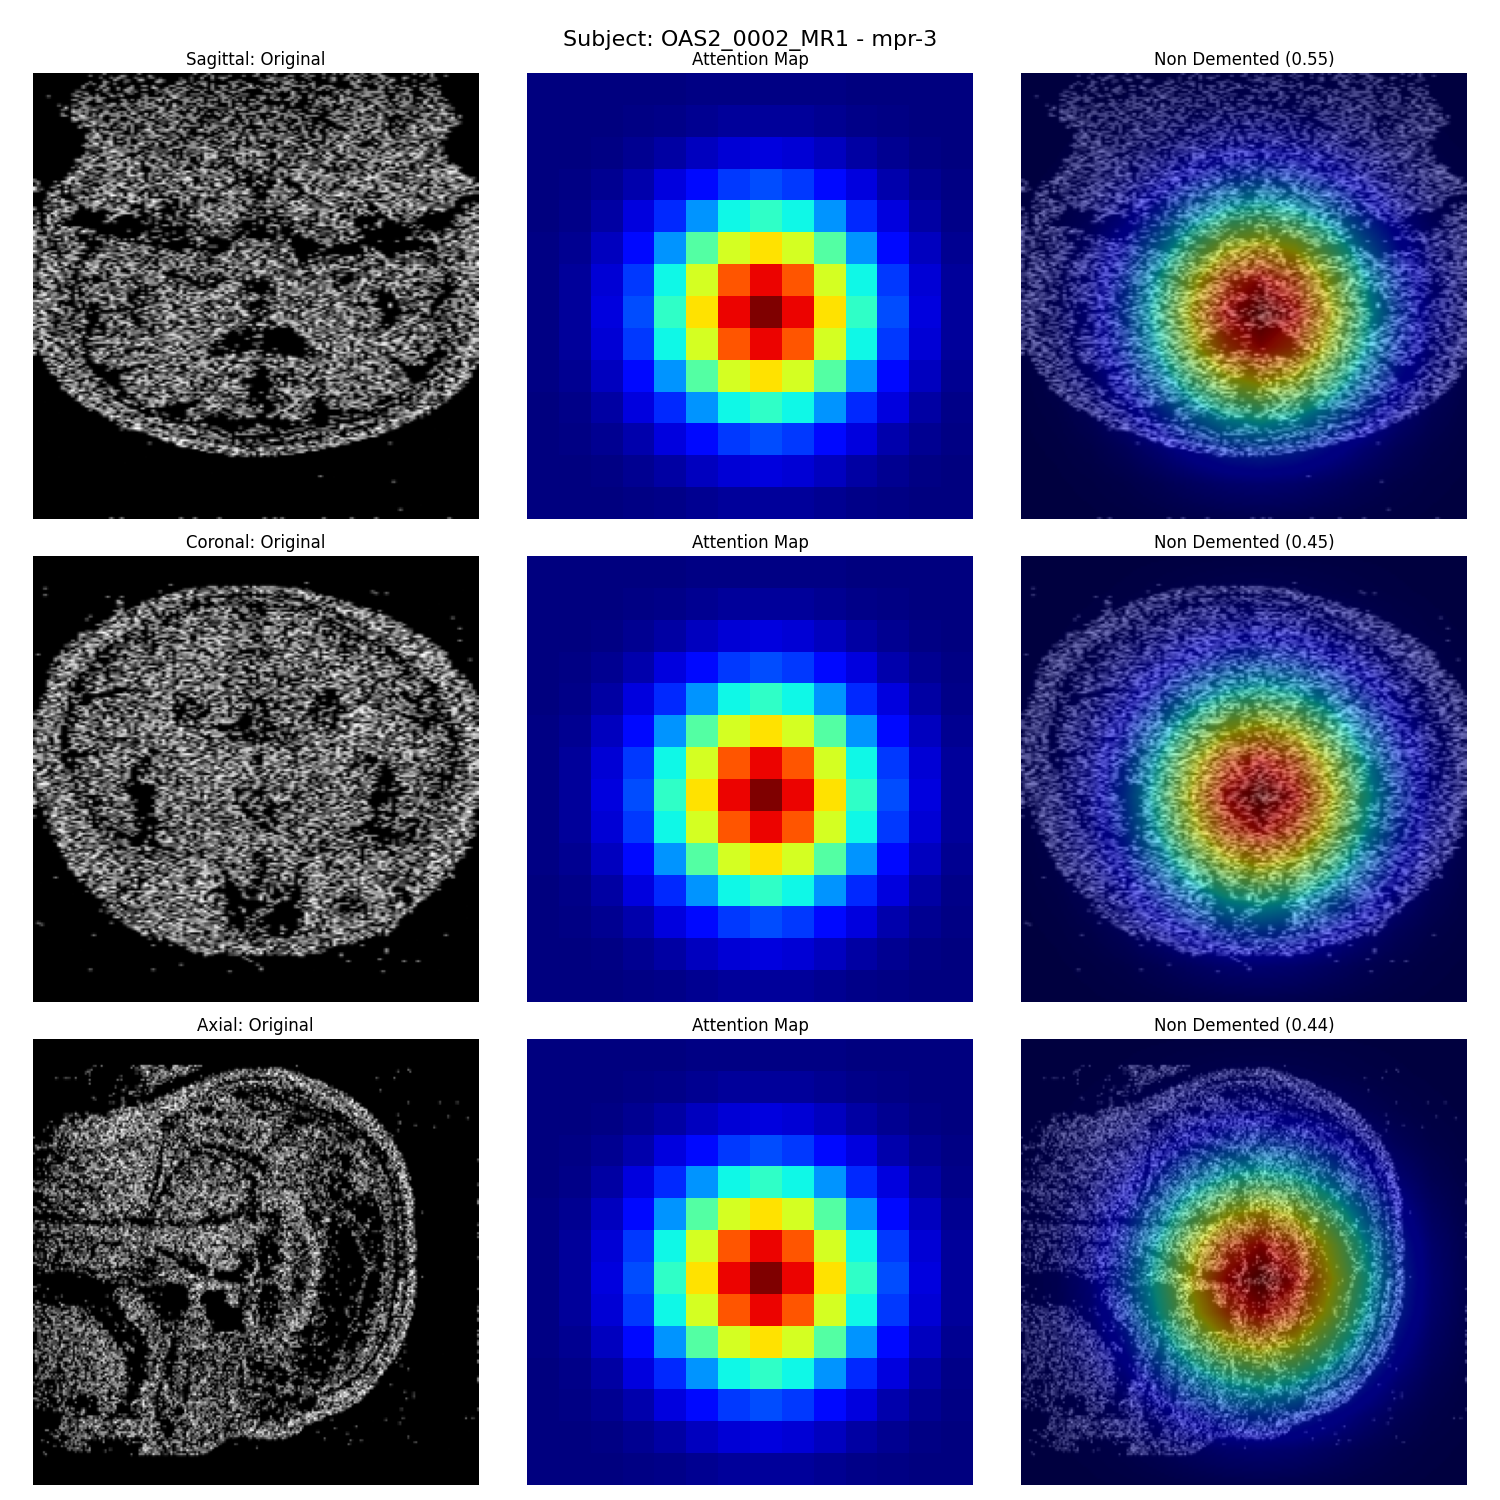
